In [2]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

In [3]:
def norm_sq_on_uniform_grid_1d_box(wf, dx):
    _abs_sq_wf = np.real(np.conj(wf) * wf)
    return dx * np.sum(_abs_sq_wf)

def normalize_on_uniform_grid_1d_box(wf, dx):
    _norm_sq = norm_sq_on_uniform_grid_1d_box(wf, dx)
    wf[:] *= 1. / np.sqrt(_norm_sq)


from numbers import Integral, Real

import numpy as np

from tdse.evol import get_D2_tridiag, get_M2_tridiag, mul_tridiag_and_diag
from tdse.tridiag import tridiag_forward, tridiag_backward

class Time_Indep_Hamil_Propagator(object):
    """A Propagator for a time-independent Hamiltonian"""
    
    def __init__(self, N, dx, Vx, hbar=1.0, m=1.0):
        
        # Check arguments
        if not isinstance(N, Integral) or not (N > 0):
            _msg = "`N` should be a positive integer. Given: {}"
            raise TypeError(_msg.format(N))
        self.N = N
        
        if not (dx > 0):
            _msg = "`dx` should be positive. Given: {}"
            raise TypeError(_msg.format(dx))
        self.dx = dx
            
        try: _Vx = np.array(Vx, copy=False)
        except:
            _msg = "Failed to convert the given potential array: `Vx`"
            raise Exception(_msg.format(Vx))
        if _Vx.shape != (N,):
            _msg = ("The potential array should have shape (N,)==({},)\n"
                    "Given: {}")
            raise TypeError(_msg.format(N, Vx))
        self.Vx = _Vx
        
        if not (hbar > 0.0) or not (m > 0.0):
            _msg = ("hbar and m (mass) should be positive\n"
                    "Given hbar = {}, m = {}")
            raise TypeError(_msg.format(hbar, m))
        self.hbar, self.m = hbar, m
        
        # Construct tridiagonals for propagation
        self.M2 = get_M2_tridiag(self.N)
        self.D2 = get_D2_tridiag(self.N, self.dx)
        _M2V = mul_tridiag_and_diag(self.M2, self.Vx)
        self.M2H = -0.5*self.hbar**2/self.m * self.D2 + _M2V
        
        
    def propagate(self, sf_arr, dt, Nt=1):
        """Propagate the given state function by the given time interval"""
        assert isinstance(sf_arr, np.ndarray) and sf_arr.dtype == np.complex
        _sf_at_mid_time = np.empty_like(sf_arr)
        _U = self.M2 - 0.5j*dt*self.M2H
        _U_adj = self.M2 + 0.5j*dt*self.M2H
        for _ in range(Nt):
            tridiag_forward(_U, sf_arr, _sf_at_mid_time)
            tridiag_backward(_U_adj, sf_arr, _sf_at_mid_time)
    
    def propagate_to_ground_state(self, sf_arr, dt=None, Nt_max=5000, 
                                  norm_thres=1e-14, Nt_per_iter=10):
        
        if dt is None: _dt = self.dx / 4.
        else:
            _dt = float(dt)
            if not isinstance(_dt, Real) or not (_dt > 0):
                _msg = "The `dt` should be real positive. Given: {}"
                raise ValueError(_msg.format(dt))    
        _imag_dt = -1.0j * _dt
        
        normalize_on_uniform_grid_1d_box(sf_arr, self.dx)
        _sf_prev = sf_arr.copy()
        
        _max_iter = int(Nt_max / Nt_per_iter) + 1
        for _i in range(_max_iter):
            self.propagate(sf_arr, _imag_dt, Nt=Nt_per_iter)
            normalize_on_uniform_grid_1d_box(sf_arr, self.dx)
            _norm_sq_of_diff = norm_sq_on_uniform_grid_1d_box(sf_arr - _sf_prev, self.dx)
            if _norm_sq_of_diff < norm_thres: break
            _sf_prev = sf_arr.copy()
        if _i >= _max_iter: raise Exception("Maximum iteration reached.")

In [4]:
Nx = 101
x_total_arr = np.linspace(0, 10.0, Nx+2)
x_arr = x_total_arr[1:-1]
Vx = np.full_like(x_arr, 0.0, dtype=float)
dx = x_arr[1] - x_arr[0]

In [5]:
prop = Time_Indep_Hamil_Propagator(Nx, dx, Vx)

# Compare the ground state with analytical solution

In [6]:
sf_arr = np.empty((Nx,), dtype=complex)
sf_arr[:] = np.random.rand(Nx)

prop.propagate_to_ground_state(sf_arr)

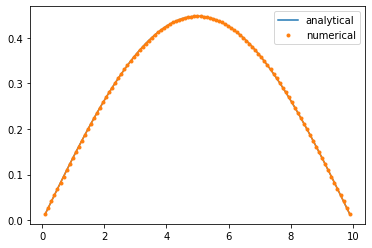

In [7]:
fig, ax = plt.subplots()
lana, = ax.plot(x_arr, np.sqrt(2./10.0)*np.sin(pi/10.0*x_arr))
lnum, = ax.plot(x_arr, sf_arr.real, '.')
ax.plot(x_arr, np.abs(sf_arr), color=lnum.get_color())
ax.legend([lana, lnum], ['analytical', 'numerical'])

# Animate propagation

In [8]:
from matplotlib.animation import FuncAnimation

%matplotlib notebook

In [9]:
t0 = 0.0
sf_t0_arr = np.sin(pi/10.0*x_arr) + 0.6*np.sin(2*pi/10.0*x_arr)
normalize_on_uniform_grid_1d_box(sf_t0_arr, dx)

<IPython.core.display.Javascript object>


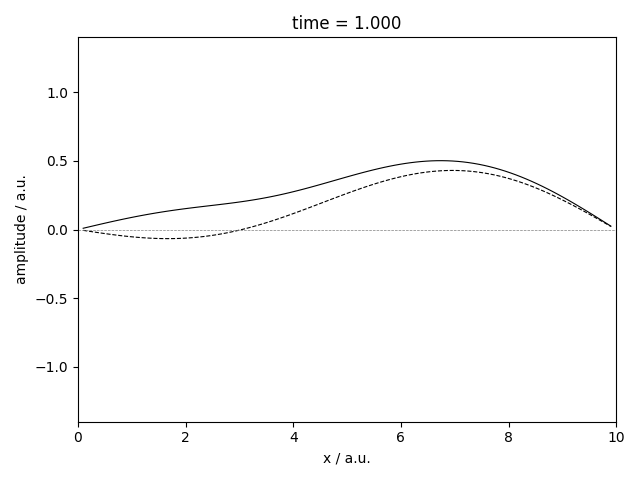

In [10]:
fig, ax = plt.subplots()

ax.set_xlim(x_total_arr[[0,-1]]), ax.set_ylim(-1.4,1.4)
ax.set_xlabel("x / a.u."), ax.set_ylabel("amplitude / a.u.")
title_form = "time = {:.3f}"
ax.set_title(title_form)

l, = ax.plot([],[],'--',linewidth=0.8,color='black')
l_env, = ax.plot([],[],linewidth=0.8,color=l.get_color())
ax.plot(ax.get_xlim(), [0,0], '--',linewidth=0.5, color='gray')

fig.tight_layout()

dt = 0.1
sf_arr = np.empty_like(x_arr, dtype=complex)

def init():
    sf_arr[:] = sf_t0_arr

def update(i):
    ax.set_title(title_form.format(t0+i*dt))
    prop.propagate(sf_arr, dt, Nt=15)
    l.set_data(x_arr, sf_arr.real)
    l_env.set_data(x_arr, np.abs(sf_arr))

ani = FuncAnimation(fig, update, frames=30, init_func=init)

In [11]:
from matplotlib.animation import PillowWriter
writer = PillowWriter(fps=5)
# ani.save("ani-test-3.gif", writer=writer)